# Coding Challenge #
In this challenge, we create a vector of portfolio weights using mean-variance optimization.<br><br>
**Source:** Huobi DM<br>
**Type:** Current quarterly futures contracts<br>
**Timeframe:** 2019-11-01T05:00:00+00:00 to 2019-11-15T23:00:00+00:00<br>
**Frequency:** 1 hour

In [1]:
# Reference: https://huobiapi.github.io/docs/dm/v1/en/#get-k-line-data
import requests
import pandas as pd
import numpy as np
import scipy.optimize as sco
from statsmodels.stats.stattools import jarque_bera
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_historical_data(ticker, period='60min'):
    url = 'https://api.hbdm.com/market/history/kline'
    params = { 'symbol': ticker, 'period': period, 'size': 2000 }
    response = requests.get(url, params=params)
    
    if response.ok:
        content = response.json()
        if content['status']=='ok':
            df = (pd.DataFrame(content['data'])
                    .assign(ret      = lambda x: x.close.pct_change(),
                            timestamp= lambda x: pd.to_datetime(x.id, unit='s').dt.tz_localize('UTC'))
                    .set_index('timestamp'))
            return df
    
    raise requests.HTTPError(response.text)

## Retrieving from Huobi DM ##
Using Huobi DM's `kline` REST API, we retrieve the latest 2,000 hourly market data, and store them into a DataFrame `df_all`.

In [3]:
dt_format = '%Y-%m-%dT%H:%M:%S%z'
start = datetime.strptime('2019-11-01T05:00:00+00:00', dt_format)
to    = datetime.strptime('2019-11-15T23:00:00+00:00', dt_format)

tickers = ['BTC', 'XRP', 'LTC']
data = { x: get_historical_data(x+'_CQ') for x in tickers }
df_all = pd.DataFrame({ k: v.ret for k, v in data.items() })[1:]
df = df_all[start:to]

`mean_returns` and `covariance_matrix` are computed - and will later be used in computation of portfolio return and volatility.<br>
Note these are **recalculated as monthly**, allowing for more intuitive interpretation.

In [4]:
time_period = 24 * 30.42
mean_returns = df.mean() * time_period
covariance_matrix = df.cov() * time_period
variances = np.diagonal(covariance_matrix)
n = mean_returns.shape[0]

## Exploratory Data Analysis ##
Prior to analysing our data, a preliminary exploration on our data would always be ideal. While financial returns are commonly assumed to be normal, the following visualizations and tests of our hourly returns show otherwise. This shows that our metric of measure - variance - does not incorporate all aspects of risks. It might, thus, be useful to further explore skewness and kurtosis.

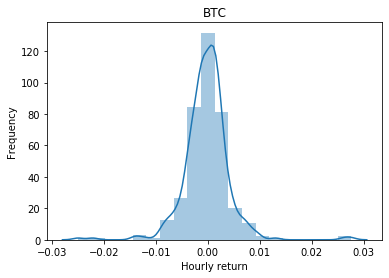

BTC p-value: 0.000; it is likely non-Gaussian


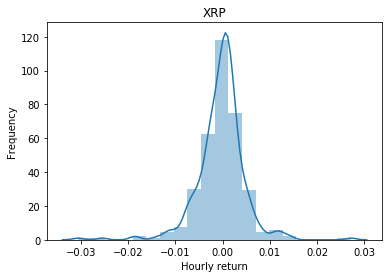

XRP p-value: 0.000; it is likely non-Gaussian


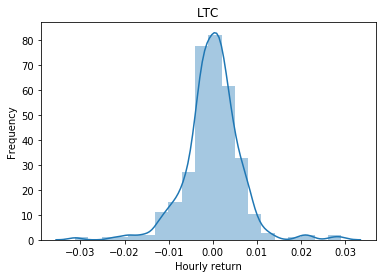

LTC p-value: 0.000; it is likely non-Gaussian


In [5]:
for col in df:
    df_ticker = df[col]
    sns.distplot(df_ticker, bins=20)
    plt.title(col)
    plt.xlabel('Hourly return')
    plt.ylabel('Frequency')
    plt.show()
    
    _, pvalue, _, _ = jarque_bera(df_ticker)
    is_normal = pvalue > .05
    print(f'{col} p-value: {pvalue:.3f}; it is likely {"Gaussian" if is_normal else "non-Gaussian"}')

## Portfolio maximization functions ##
With reference to Yves Hilpisch's *Python for Finance*, the helper methods below are defined to aid with portfolio optimization.

In [6]:
# Reference: https://stackoverflow.com/a/44546435
def statistics(weights):
    port_ret = np.sum(mean_returns * weights)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(covariance_matrix, weights)))
    return np.array([port_ret, port_vol, port_ret / port_vol])

# Helper functions that we will optimize
def port_return(weights):
    return -statistics(weights)[0]
    
def port_volatility(weights):
    return statistics(weights)[1]

def port_sharpe(weights):
    return -statistics(weights)[2]

In [7]:
# Parameters for scipy optimization
guess = np.array(n * [1/n])
constraints = [{'type': 'eq', 'fun': lambda x: np.sum(abs(x)) - 1. },
               {'type': 'ineq', 'fun': lambda x: statistics(x)[0] }]
bounds = tuple((-1, 1) for x in range(n))
kwargs =  { 'method': 'SLSQP', 'bounds': bounds, 'constraints': constraints }

## Portfolio that maximizes Sharpe ratio ##
We find the weights allocation that maximizes the Sharpe ratio (defined as $\frac{r_p - r_f}{\sigma_p}$).<br>
While we do not reference any risk-free rate (hence $r_f=0$ and Sharpe is simply $\frac{r_p}{\sigma_p}$), the computation is still relevant as maximizing our risk-adjusted returns.

In [8]:
# basinhopping (instead of minimize) is used as this helps avoid a local minimum
max_sharpe_opt = sco.basinhopping(port_sharpe, guess, minimizer_kwargs=kwargs)   
max_sharpe_port = statistics(max_sharpe_opt.x)[:2]

## Mean-variance efficient frontier ##
Also, we wish to find our mean-variance efficient frontier: a set of portfolios that offer the lowest volatility given a target return.<br>
We iterate through a list of target returns `t_rets`, and minimize the volatility at each turn.

In [9]:
ef_constraints = [{'type': 'eq', 'fun': lambda x: np.sum(abs(x)) - 1. }]

max_return = max([abs(x) for x in mean_returns])
t_rets, t_vols = np.linspace(.09, max_return, 50), []
min_vol, min_vol_weights = np.inf, None

In [ ]:
for t_ret in t_rets:
    t_constraints = ef_constraints + [{'type': 'eq', 'fun': lambda x: statistics(x)[0] - t_ret }]
    min_kwargs = { 'method': 'SLSQP', 'bounds': bounds, 'constraints': t_constraints }
    opt = sco.basinhopping(port_volatility, guess, niter=20, stepsize=.5, minimizer_kwargs=min_kwargs)
    t_vols.append(opt.fun)
    
    if opt.fun < min_vol:
        min_vol = opt.fun
        min_vol_weights = opt.x

### Minimum variance portfolio ###
We select the portfolio that minimizes volatility - and by extension - volatility, from within our efficient frontier.

In [ ]:
# Choose min-vol portfolio from within Efficient Frontier
min_vol_port = statistics(min_vol_weights)[:2]

## Export to CSV ##
Having found our maximum Sharpe and minimum variance portfolios, we export their allocation weights to CSV.

In [ ]:
export_filename = 'portfolio_weights.csv'
df_weights = pd.DataFrame({ 'Max Sharpe': max_sharpe_opt.x, 'Min Volatility': min_vol_weights }, index=tickers)
df_weights.to_csv(export_filename)

## Plot of Efficient Frontier ##
Using `matplotlib`, we plot our numerical optimizations of our mean-variance efficient frontier; with our Max Sharpe and Minimum Volatility portfolio characteristics plotted as stars.

In [ ]:
df_frontier = pd.DataFrame({ 'return': t_rets, 'volatility': t_vols })
plt.scatter(x=t_vols, y=t_rets, c=t_rets/t_vols, marker='x')

plt.plot(min_vol_port[1], min_vol_port[0], 'r*', markersize=15.0, label='Min Volatility')
plt.plot(max_sharpe_port[1], max_sharpe_port[0], 'b*', markersize=15.0, label='Max Sharpe')

plt.grid(True)
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.colorbar(label='Sharpe ratio')
plt.legend()
plt.show()

## Future Performance ##
Can we see how our optimized portfolios perform in the future?<br>
It turns out because we are using historical data, we can do that for the same horizon as our analysis.

In [ ]:
# We also compare with naive long/short equal-weighted allocations
weights = { 'Min Volatility': min_vol_weights, 'Max Sharpe': max_sharpe_opt.x,
            'Long Equal-Weighted': guess, 'Short Equal-Weighted': guess*-1 }
future_pfs = {}
future_pf_metrics = {}

for pf_name, weight in weights.items():
    df_future = df_all[to:][1:df.shape[0]+1]
    pf_returns = (weight * df_future).sum(axis=1)
    future_pfs[pf_name] = (100 * (1+pf_returns).cumprod())
    
    f_return = pf_returns.mean() * time_period
    f_volatility = pf_returns.std(ddof=1) * (time_period**.5)
    future_pf_metrics[pf_name] = [f_return, f_volatility, f_return/f_volatility]

df_future = pd.DataFrame(future_pfs)
future_title = 'Returns (Start=100)'

It appears our Max Sharpe portfolio outperforms our Min Volatility portfolio. Although the Min Volatility portfolio faces far less fluctation, it ends the investment horizon barely breaking even, while the Max Sharpe portfolio closes 2.4% higher.

In [ ]:
df_future.iloc[:,:2].plot(title=future_title)
plt.show()

On the other hand, our short equal-weighted portfolio displays a phenomenal Sharpe of 1.55, closing at 15.4% higher than in mid-Nov. This has been a bearish November for cryptocurrencies!

In [ ]:
df_future.iloc[:,2:].plot(title=future_title)
plt.show()